In [242]:
# Making necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
import random
import time
from hmmlearn import hmm
import numpy as np
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import nltk
nltk.download('words')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from abc import ABC, abstractmethod

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [243]:
# reading the dataset
djia_dataset = pd.read_csv("DJA.csv")

In [244]:
djia_dataset = djia_dataset.dropna()

In [245]:
# reading the dataset
snp = pd.read_csv("SNP.csv")
snp = snp[1075:1829]
nasdaq = pd.read_csv("NASDAQCOM.csv")

Text(0, 0.5, 'Stock Close Price')

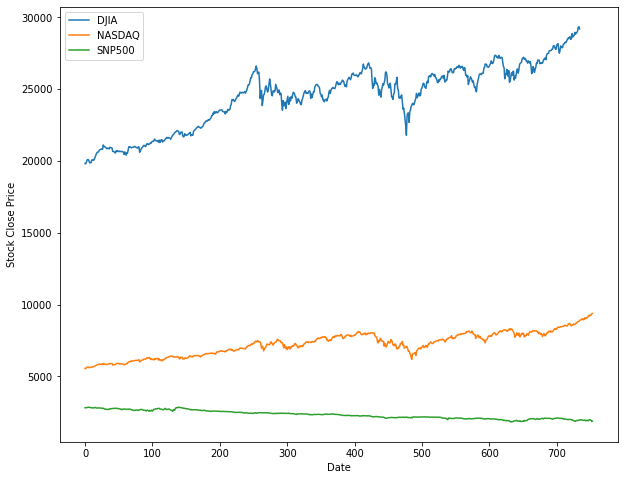

In [246]:
# Plot actual trend of data
fig = plt.figure(figsize=(10,8))
plt.plot(djia_dataset["DJIA"].tolist(), label='DJIA')
plt.plot(nasdaq["Close"].tolist(), label='NASDAQ')
plt.plot(snp["Close/Last"].tolist(), label='SNP500')
plt.legend(loc='upper left')
plt.xlabel("Date")
plt.ylabel("Stock Close Price")

In [247]:
# Function to calculate the variation
def find_variation(close_prices):
    variation = [0]
    for i in range(1, len(close_prices)):
        variation.append(((close_prices[i] - close_prices[i-1])/close_prices[i])*100)
    return variation

Text(0, 0.5, 'Variation')

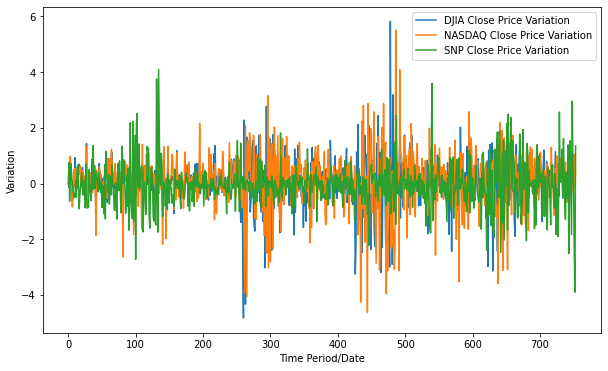

In [248]:
# Calculating and displaying variation
djia_variation = find_variation(djia_dataset["DJIA"].tolist())
snp_variation = find_variation(snp["Close/Last"].tolist())
nasdaq_variation = find_variation(nasdaq["Close"].tolist())
fig = plt.figure(figsize=(10,6))
plt.plot(djia_variation, label = 'DJIA Close Price Variation')
plt.plot(nasdaq_variation, label = 'NASDAQ Close Price Variation')
plt.plot(snp_variation, label='SNP Close Price Variation')
plt.legend(loc='upper right')
plt.xlabel('Time Period/Date')
plt.ylabel('Variation')

In [249]:
# Function to generate random transition matrix and starting probability
def generate_random_transition_matrix():
    k = 8
    result = [[random.uniform(0, 0.1 / k) for i in range(k)] for j in range(k)]
    for j, r in enumerate(result):
        r[j] += 1 - sum(r)
    return np.asarray(result)
def generate_random_start_prob():
    k = 8
    start_prob = [np.random.uniform(0,1) for _ in range(k)]
    start_prob = np.asarray(start_prob)
    start_prob = start_prob/np.sum(start_prob)
    return np.asarray(start_prob)

In [250]:
# CSP Solver
from queue import PriorityQueue
from abc import ABC, abstractmethod


class Constraint(ABC):
    def __init__(self, variables):
        self.variables = variables

    @abstractmethod
    def satisfied(self, assignment):
        pass


class CSP():
    def __init__(self, variables, domains):
        self.variables = variables
        self.domains = domains
        self.constraints = {}
        for variable in self.variables:
            self.constraints[variable] = []
            if variable not in self.domains:
                raise LookupError(
                    'Every variable should have a domain assigned to it.')

    def add_constraint(self, constraint):
        for variable in constraint.variables:
            if variable not in self.variables:
                raise LookupError("Variable in constraint not in CSP")
            else:
                self.constraints[variable].append(constraint)

    def consistent(self, variable, assignment):
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True

    def backtracking_search(self, assignment={}):
        # assignment is complete if every variable is assigned (our base case)
        if len(assignment) == len(self.variables):
            return assignment
        # get all variables in the CSP but not in the assignment
        unassigned = [v for v in self.variables if v not in assignment]
        first = unassigned[0]
        for value in self.domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            # if we're still consistent, we recurse (continue)
            if self.consistent(first, local_assignment):
                result = self.backtracking_search(local_assignment)
                if result is not None:
                    return result
        return None


class Constraint(Constraint):
    def __init__(self, place1, place2):
        super().__init__([place1, place2])
        self.place1 = place1
        self.place2 = place2

    def satisfied(self, assignment):
        if self.place1 not in assignment or self.place2 not in assignment:
            return True
        return assignment[self.place1] != assignment[self.place2]

In [251]:
# Trump Tweet Sentiment Analysis
sid = SentimentIntensityAnalyzer()
words = set(nltk.corpus.words.words())
real_donald_trump = pd.read_csv("realdonaldtrump.csv")
trump_tweets = pd.read_csv("trumptweets.csv")
cond1 = real_donald_trump['date'] >= "2017-01-20"
cond2 = real_donald_trump['date'] <= "2020-01-20"
real_donald_trump = real_donald_trump.where((cond1 & cond2)).dropna()
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet)
         if w.lower() in words or not w.isalpha())
    return tweet
    

real_donald_trump['content_clean'] = real_donald_trump['content'].apply(cleaner)
word_dict = {'manipulate':-1,'manipulative':-1,'jamescharlesiscancelled':-1,'jamescharlesisoverparty':-1,
            'pedophile':-1,'pedo':-1,'cancel':-1,'cancelled':-1,'cancel culture':0.4,'teamtati':-1,'teamjames':1,
            'teamjamescharles':1,'liar':-1,'MAGA':-1}


sid = SentimentIntensityAnalyzer()
sid.lexicon.update(word_dict)

list1 = []
for i in real_donald_trump['content_clean']:
    list1.append((sid.polarity_scores(str(i)))['compound'])
real_donald_trump['sentiment'] = list1

In [252]:
# defining a dictionary of states
states_dict = {
    0: 'very-small-rise',
    1: 'small-rise',
    2: 'large-rise',
    3: 'very-large-rise',
    4: 'very-small-drop',
    5: 'small-drop',
    6: 'large-drop',
    7: 'very-large-drop',
}

In [253]:
# Function to train HMM without CSP
def training_hmm_without_csp(training_data):
    start_prob = generate_random_start_prob()
    transition_matrix = generate_random_transition_matrix()
    model = hmm.GMMHMM(n_components=8, n_mix = 7, covariance_type="diag", n_iter=10)
    model.fit(training_data)
    return model

In [254]:
# Function to train HMM with CSP
def training_hmm_with_csp(training_data, tweet_dataset):
    start_prob = generate_random_start_prob()
    transition_matrix = generate_random_transition_matrix()

    variables = [
    "0","1","2","3","4","5","6","7"
    ]
    domains = {
        "0":["0","1"],
        "1":["0","1"],
        "2":["0","1"],
        "3":["0","1"],
        "4":["0","1"],
        "5":["0","1"],
        "6":["0","1"],
        "7":["0","1"],
        "8":["0","1"],
    }
    csp = CSP(variables, domains)

    tweet_sentiment = tweet_dataset["sentiment"].tolist()
    # Adding constraints to our model
    for i in range(len(tweet_sentiment)):
        if(tweet_sentiment[i] >= 0.9): csp.add_constraint(Constraint("4","3"))
        if(tweet_sentiment[i] >= 0.6 and tweet_sentiment[i] < 0.9): csp.add_constraint(Constraint("1","2"))
        if(tweet_sentiment[i] >= 0.3 and tweet_sentiment[i] < 0.1): csp.add_constraint(Constraint("4","5"))
        else: csp.add_constraint(Constraint("6","7"))

    solution = csp.backtracking_search()
    transition_matrix = np.identity(8)
    model = hmm.GMMHMM(n_components=8, n_mix = 7, covariance_type="diag", n_iter=10)
    model.transmat_ = transition_matrix
    model.fit(training_data)

    return model
    

In [255]:
# Predict the index of states (hidden states)
def calculate_index_states(model, X_test):
    X_test = np.asarray(X_test).reshape(-1,1)
    index_states = model.predict(X_test)
    return index_states

In [256]:
# Classify the actual variation of each state (Index)
def classify_state_variation(variations):
    states = []
    for variation in variations:
        if(0 <= variation and variation < 0.1):
            states.append(0)
        elif(0.1 <= variation and variation < 1):
            states.append(1)
        elif(1 <= variation and variation < 2):
            states.append(2)
        elif(variation >= 2):
            states.append(3)
        elif(-0.1 < variation and variation <= 0):
            states.append(4)
        elif(-1 < variation and variation <= -0.1):
            states.append(5)
        elif(-2 < variation and variation <= -1):
            states.append(6)
        elif(variation <= -2):
            states.append(7)
    return states

In [257]:
# Classify the actual variation of each state (Index)

nasdaq_states = classify_state_variation(nasdaq_variation)

In [258]:
# Choosing best out of 100 models with out CSP

def choose_best_model_without_csp(data):
    X = data
    X_train = X[:int(0.8*len(X))]
    X_test = X[int(0.8*len(X)):]
    X_train = np.asarray(X_train).reshape(-1, 1)
    X_test = np.asarray(X_test).reshape(-1, 1)
    model = training_hmm_without_csp(X_train)
    best_model = model.fit(X_train)
    best_model_score = best_model.score(X_test)
    print("Model 1: Score = " + str(best_model_score))
    for i in range(2,101):
        model = training_hmm_without_csp(X_train)
        print("Model " + str(i) + ": Score = " + str(model.score(X_test)))
        if(model.score(X_test) >= best_model_score):
            best_model_score = model.score(X_test)
            best_model = model

    print("Best Model Found - Score = " + str(best_model_score))
    return best_model, best_model_score

In [259]:
# Choosing best out of 100 models with CSP
def choose_best_model_with_csp(data, tweet_dataset):
    X = data
    X_train = X[:int(0.8*len(X))]
    X_test = X[int(0.8*len(X)):]
    X_train = np.asarray(X_train).reshape(-1, 1)
    X_test = np.asarray(X_test).reshape(-1, 1)
    model = training_hmm_without_csp(X_train)
    best_model = model.fit(X_train)
    best_model_score = best_model.score(X_test)
    print("Model 1: Score = " + str(best_model_score))
    for i in range(2,101):
        model = training_hmm_with_csp(X_train, tweet_dataset)
        print("Model " + str(i) + ": Score = " + str(model.score(X_test)))
        if(model.score(X_test) >= best_model_score):
            best_model_score = model.score(X_test)
            best_model = model

    print("Best Model Found - Score = " + str(best_model_score))
    return best_model, best_model_score

In [260]:
# Calculate best model params and score
nasdaq_dataset_normalized = np.asarray(nasdaq["Close"].tolist())
nasdaq_dataset_normalized = nasdaq_dataset_normalized/sum(nasdaq_dataset_normalized)
nasdaq_dataset_normalized = nasdaq_dataset_normalized.tolist()

best_model_without_csp, best_model_without_csp_score = choose_best_model_without_csp(nasdaq_dataset_normalized)
best_model_with_csp, best_model_with_csp_score = choose_best_model_with_csp(nasdaq_dataset_normalized, real_donald_trump)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


Model 1: Score = 746.2068453169443
Model 2: Score = 630.8141510495358
Model 3: Score = 866.8867828841827
Model 4: Score = 892.1554498662014
Model 5: Score = 913.6063544899414
Model 6: Score = 689.5516360059185
Model 7: Score = 460.06483109398033
Model 8: Score = 778.4607447233332
Model 9: Score = 746.1609661403011
Model 10: Score = 520.3995600574456
Model 11: Score = 497.8373214778328
Model 12: Score = 621.418348982357
Model 13: Score = 704.6068726961059
Model 14: Score = 849.6616635426176
Model 15: Score = 660.8930678762979
Model 16: Score = 143.23417851703792
Model 17: Score = 789.3084956743123
Model 18: Score = 583.3908113423515
Model 19: Score = 840.2767497852105
Model 20: Score = 763.1313003257226
Model 21: Score = 221.39716676387317
Model 22: Score = 99.65657571297595
Model 23: Score = 763.9732853009451
Model 24: Score = 799.5998166077252
Model 25: Score = 118.85526361426928
Model 26: Score = 619.4485963794668
Model 27: Score = 48.0346749671744
Model 28: Score = 517.032394398428


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 1: Score = 794.5245490467538


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 2: Score = 449.43674533327965


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 3: Score = 780.9306992971638


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 4: Score = 572.3835554441562


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 5: Score = 591.2656742728279


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 6: Score = 674.5205293164819


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 7: Score = 793.4880975960153


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 8: Score = 779.393783951332


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 9: Score = 682.8700930848191


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 10: Score = 736.6232268384247


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 11: Score = 656.2732855474395


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 12: Score = -27.984463427859716


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 13: Score = 700.3978720840968


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 14: Score = 397.57019684800485


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 15: Score = 585.0113171639767


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 16: Score = 723.8913611212053


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 17: Score = 789.3535458578589


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 18: Score = 665.7031024795397


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 19: Score = 674.5201133089735


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 20: Score = 664.6039487340104


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 21: Score = 665.376257327459


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 22: Score = 428.97142820578694


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 23: Score = 761.9052793265772


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 24: Score = 793.7674438912914


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 25: Score = 735.2756253888773


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 26: Score = 508.051063834264


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 27: Score = 692.5147065306594


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 28: Score = 776.6810449987532


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 29: Score = 803.9749391398708


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 30: Score = 752.3503969156832


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 31: Score = 385.9883939911158


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 32: Score = 658.6672159820575


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 33: Score = 716.689545320919


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 34: Score = 606.085824241092


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 35: Score = 463.8290526335176


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 36: Score = 604.6380836895994


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 37: Score = -328.2929116202102


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 38: Score = 705.0725263369956


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 39: Score = -87.78000472713663


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 40: Score = 686.4421945598023


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 41: Score = 706.6675312915529


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 42: Score = 640.1312959442288


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 43: Score = 727.9231351145028


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 44: Score = 776.5036059246527


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 45: Score = 714.3872843435921


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 46: Score = 746.3537448801532


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 47: Score = 745.0729734163315


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 48: Score = 486.3584343508225


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 49: Score = 665.7844243980597


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 50: Score = 462.7807795067443


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 51: Score = 848.716474058907


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 52: Score = 657.5414037988515


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 53: Score = 629.803006230495


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 54: Score = 753.9011758910943


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 55: Score = 808.3543618851572


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 56: Score = 777.9683799055764


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 57: Score = 670.8626494118839


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 58: Score = 784.1227915023782


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 59: Score = 672.7887083046838


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 60: Score = 695.6486834676607


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 61: Score = 591.7367932532641


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 62: Score = 603.34198737575


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 63: Score = 639.0949290567976


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 64: Score = 810.1810193988669


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 65: Score = 811.2060294431332


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 66: Score = 591.681712693197


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 67: Score = 918.8883667551863


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 68: Score = 774.080825990452


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 69: Score = 918.3034668644892


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 70: Score = 820.7234528703628


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 71: Score = 415.96238880139003


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 72: Score = 718.6070809725112


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 73: Score = 578.8238298051806


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 74: Score = 788.0124659472727


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 75: Score = 587.5371728069925


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 76: Score = 606.1285551000494


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 77: Score = 508.68104482791244


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 78: Score = 763.4004512535109


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 79: Score = 625.8315793198124


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 80: Score = 802.6177277503093


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 81: Score = 642.429745979902


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 82: Score = 720.4645719252011


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 83: Score = 796.7125891724851


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 84: Score = 653.6591032447429


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 85: Score = 664.4008385407291


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 86: Score = 697.1657754443124


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 87: Score = 296.301986667001


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 88: Score = 448.0459684194406


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 89: Score = 782.0105586256411


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 90: Score = 800.0795795591807


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 91: Score = 611.3901242588767


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 92: Score = 722.3717151376358


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 93: Score = 784.9448615552136


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 94: Score = 560.5166299728842


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 95: Score = 899.0404702940058


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 96: Score = 608.6093098951486


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 97: Score = 696.3822843744023


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 98: Score = 787.6959570333802


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 99: Score = 737.8387830601581
Model 100: Score = 706.2401486007467
Best Model Found - Score = 918.8883667551863


In [261]:
# Calculate index of states
index_states_without_csp = calculate_index_states(best_model_without_csp, nasdaq_dataset_normalized[int(0.8*len(nasdaq_dataset_normalized)):])
index_states_with_csp = calculate_index_states(best_model_with_csp, nasdaq_dataset_normalized[int(0.8*len(nasdaq_dataset_normalized)):])

In [262]:
nasdaq_states_testing = nasdaq_states[int(0.8*len(nasdaq_dataset_normalized)):]

In [263]:
# Count correct predictions
def correct_predictions(actual_states, calculated_states):
    count = 0
    for i in range(len(actual_states)):
        if(abs(actual_states[i] - calculated_states[i]) <= 3):
            count += 1
    return count

In [264]:
# Calculate Accuracy
accuracy_without_csp = correct_predictions(nasdaq_states_testing, index_states_without_csp)/len(nasdaq_states_testing)
accuracy_with_csp = correct_predictions(nasdaq_states_testing, index_states_with_csp)/len(nasdaq_states_testing)

In [278]:
accuracy_without_csp

0.6291390728476821

In [266]:
# Calculate MAPE
def calculate_mape(actual_states, calculated_states):
    count = 0
    for i in range(len(actual_states)):
        count = count + abs((actual_states[i] - calculated_states[i])/(actual_states[i]+100))
    return (count/len(calculated_states))*100

In [267]:
calculate_mape(nasdaq_states_testing, index_states_without_csp)

2.521994890430583

In [268]:
# Predict Prices
def predict_prices(data, index_states):
    X = data
    price_variation = [-3,-2,-1,-0.1,0.1,1,2,3]
    predicted_prices = [X[int(0.8*len(X))-1]]
    for i in range(1, int(0.2*len(X))):
        new_price = predicted_prices[i-1] + predicted_prices[i-1]*price_variation[index_states[i]]/100
        predicted_prices.append(new_price)
    return predicted_prices    

In [269]:
predict_prices_without_csp = predict_prices(nasdaq_dataset_normalized, index_states_without_csp)
predict_prices_with_csp = predict_prices(nasdaq_dataset_normalized, index_states_with_csp)

Text(0.5, 1.0, 'State transition without and with CSP - NASDAQ')

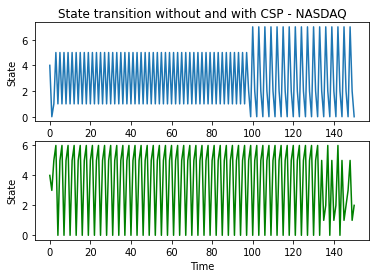

In [277]:
# State Transition
#fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots(2)
ax[0].plot(index_states_without_csp, label = 'State transition without CSP')
ax[1].plot(index_states_with_csp,label = 'State transition with CSP', color='green')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("State")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("State")
ax[0].set_title('State transition without and with CSP - NASDAQ')

Text(0, 0.5, 'NASDAQ Index Value')

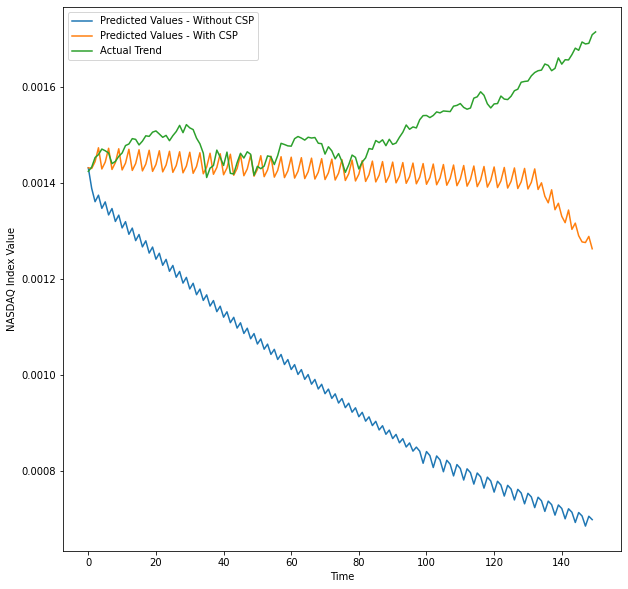

In [271]:
# plot predicted trend vs actual trend
fig = plt.figure(figsize=(10,10))
plt.plot(predict_prices_without_csp, label = 'Predicted Values - Without CSP')
plt.plot(predict_prices_with_csp, label = 'Predicted Values - With CSP')
plt.plot(nasdaq_dataset_normalized[int(0.8*len(nasdaq_dataset_normalized)):], label = 'Actual Trend')
plt.legend(loc = 'upper left')
plt.xlabel("Time")
plt.ylabel("NASDAQ Index Value")

In [272]:
#import pickle
#with open("bestfitdjiamodeln.pkl", "wb") as f: 
#    pickle.dump(best_model, f)

In [273]:
X = snp["Close/Last"].tolist()
X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):]
X_train = np.asarray(X_train).reshape(-1, 1)
X_test = np.asarray(X_test).reshape(-1, 1)

In [274]:
# Find time complexity
def finding_model_time(X_train, tweet_dataset):
    start_time = time.time()
    model = training_hmm_without_csp(X_train)
    print("--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
    model = training_hmm_with_csp(X_train, tweet_dataset)
    print("--- %s seconds ---" % (time.time() - start_time))

In [275]:
finding_model_time(X_train, real_donald_trump)

Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


--- 0.24598002433776855 seconds ---
--- 0.23444604873657227 seconds ---
